In [10]:
import pandas as pd
import warnings
import os
import sys
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt

root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

sys.path.insert(0, root_dir)

from config import DATA_PATH

# Show all columns
pd.set_option('display.max_columns', None)

In [11]:
df = pd.read_csv(os.path.join(DATA_PATH, 'balanced_data.csv'))

df.head()

,day_of_week,age_band_of_driver,educational_level,driving_experience,service_year_of_vehicle,defect_of_vehicle,number_of_vehicles_involved,number_of_casualties,age_band_of_casualty,casualty_severity,sex_of_driver_female,sex_of_driver_male,type_of_vehicle_automobile,type_of_vehicle_bajaj,type_of_vehicle_bicycle,type_of_vehicle_long lorry,type_of_vehicle_lorry (11?40q),type_of_vehicle_lorry (41?100q),type_of_vehicle_motorcycle,type_of_vehicle_other,type_of_vehicle_pick up upto 10q,type_of_vehicle_public (12 seats),type_of_vehicle_public (13?45 seats),type_of_vehicle_public (> 45 seats),type_of_vehicle_ridden horse,type_of_vehicle_special vehicle,type_of_vehicle_stationwagen,type_of_vehicle_taxi,type_of_vehicle_turbo,owner_of_vehicle_governmental,owner_of_vehicle_organization,owner_of_vehicle_other,owner_of_vehicle_owner,area_accident_occured_church areas,area_accident_occured_hospital areas,area_accident_occured_industrial areas,area_accident_occured_market areas,area_accident_occured_office areas,area_accident_occured_other,area_accident_occured_outside rural areas,area_accident_occured_recreational areas,area_accident_occured_residential areas,area_accident_occured_rural village areas,area_accident_occured_school areas,lanes_or_medians_divided two-way,lanes_or_medians_double carriageway (median),lanes_or_medians_one way,lanes_or_medians_other,lanes_or_medians_undivided two way,road_allignment_escarpments,road_allignment_gentle horizontal curve,road_allignment_sharp reverse curve,road_allignment_steep grade downward with mountainous terrain,road_allignment_steep grade upward with mountainous terrain,road_allignment_tangent road with flat terrain,road_allignment_tangent road with mild grade and flat terrain,road_allignment_tangent road with mountainous terrain and,road_allignment_tangent road with rolling terrain,types_of_junction_crossing,types_of_junction_no junction,types_of_junction_o shape,types_of_junction_other,types_of_junction_t shape,types_of_junction_x shape,types_of_junction_y shape,road_surface_type_aspahlt roads,road_surface_type_asphalt roads,road_surface_type_earth roads,road_surface_type_gravel roads,road_surface_type_other,road_surface_conditions_dry,road_surface_conditions_flood over 3cm. deep,road_surface_conditions_snow,road_surface_conditions_wet or damp,light_conditions_darkness,light_conditions_daylight,weather_conditions_cloudy,weather_conditions_fog or mist,weather_conditions_normal,weather_conditions_other,weather_conditions_raining,weather_conditions_raining and windy,weather_conditions_snow,weather_conditions_windy,type_of_collision_collision with animals,type_of_collision_collision with pedestrians,type_of_collision_collision with roadside objects,type_of_collision_collision with roadside-parked vehicles,type_of_collision_fall from vehicles,type_of_collision_other,type_of_collision_rollover,type_of_collision_vehicle with vehicle collision,type_of_collision_with train,vehicle_movement_entering a junction,vehicle_movement_getting off,vehicle_movement_going straight,vehicle_movement_moving backward,vehicle_movement_other,vehicle_movement_overtaking,vehicle_movement_parked,vehicle_movement_reversing,vehicle_movement_stopping,vehicle_movement_turnover,vehicle_movement_u-turn,vehicle_movement_waiting to go,casualty_class_driver or rider,casualty_class_passenger,casualty_class_pedestrian,sex_of_casualty_female,sex_of_casualty_male,work_of_casuality_driver,work_of_casuality_employee,work_of_casuality_other,work_of_casuality_self-employed,work_of_casuality_student,work_of_casuality_unemployed,fitness_of_casuality_blind,fitness_of_casuality_deaf,fitness_of_casuality_normal,fitness_of_casuality_other,pedestrian_movement_crossing from driver's nearside,pedestrian_movement_crossing from nearside - masked by parked or stationot a pedestrianry vehicle,pedestrian_movement_crossing from offside - masked by parked or stationot a pedestrianry vehicle,"pedestrian_movement_in carriageway, stationot a pedestrianry - not 

In [12]:
y = df['accident_severity']
X = df.drop('accident_severity', axis=1)

In [13]:
X['day_of_week_sin'] = np.sin(2 * np.pi * X['day_of_week'] / 7)
X['day_of_week_cos'] = np.cos(2 * np.pi * X['day_of_week'] / 7)
X = X.drop(columns=['day_of_week'])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(y.unique()),  
    eval_metric='mlogloss',  
    random_state=42
)

In [16]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_class=3, num_parallel_tree=None, objective='multi:softprob', ...)

In [17]:
y_pred = model.predict(X_test)

In [18]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("F1 Score: {:.2f}%".format(f1_score(y_test, y_pred, average='weighted') * 100))

Accuracy: 92.83%
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.97      0.91      2064
           1       0.96      0.83      0.89      2122
           2       0.98      0.99      0.99      2063

    accuracy                           0.93      6249
   macro avg       0.93      0.93      0.93      6249
weighted avg       0.93      0.93      0.93      6249

Confusion Matrix:
[[2000   62    2]
 [ 329 1760   33]
 [  19    3 2041]]
F1 Score: 92.79%


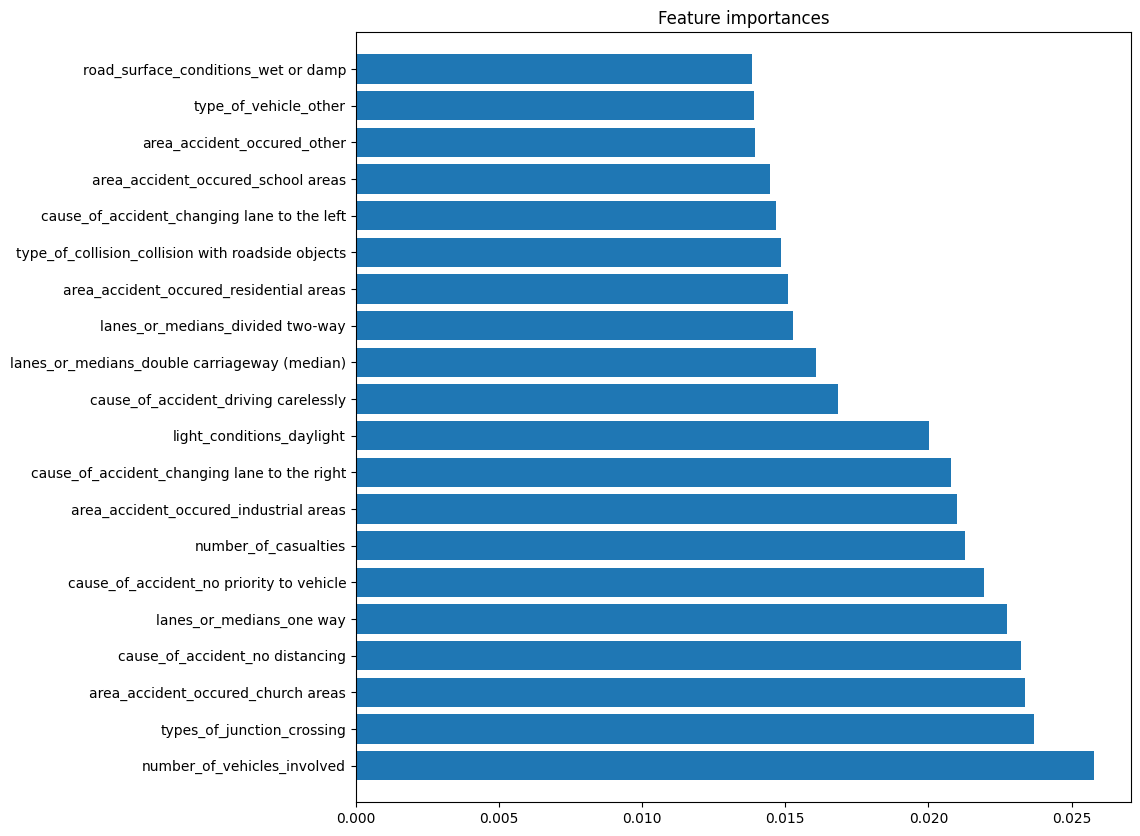

In [19]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]
top_features = X.columns[sorted_idx][:20]
X_selected_tree = X[top_features]
# Plot the feature importances of the forest
plt.figure(figsize=(10, 10))
plt.title("Feature importances")
plt.barh(range(len(top_features)), feature_importance[sorted_idx][:20], align="center")
plt.yticks(range(len(top_features)), top_features)
plt.ylim([-1, len(top_features)])
plt.show()

In [20]:
# Save to csv
X_selected_tree.to_csv(os.path.join(DATA_PATH, 'X_selected_tree.csv'), index=False)